In [1]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.pyplot as plt

/home/clem/Documents/source/sandbox/webstat_tsclustering/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
CLIENT_ID = "aa94502c-1518-4c17-9fba-88f7e6580baf"
API_URL = "api.webstat.banque-france.fr"

# Récupération de la liste des datasets

In [ ]:
conn = http.client.HTTPSConnection(API_URL)

headers = {
    'X-IBM-Client-Id': CLIENT_ID,
    'accept': "application/json"
    }

conn.request("GET", "/webstat-fr/v1/catalogue?format=json", headers=headers)

res = conn.getresponse()
data = res.read()

annuaire_dict = data.decode("utf-8")
annuaire_dict = json.loads(annuaire_dict)
dataset_names = [dataset["name"] for dataset in annuaire_dict]

In [ ]:
dataset_names

# Récupération de la liste des séries d'un dataset

In [ ]:
dataset_name = dataset_names[0]
dataset_name = "STS"

In [ ]:
conn = http.client.HTTPSConnection(API_URL)

headers = {
    'X-IBM-Client-Id': CLIENT_ID,
    'accept': "application/json"
    }

conn.request("GET", f"/webstat-fr/v1/catalogue/{dataset_name}?format=json", headers=headers)

res = conn.getresponse()
data = res.read()

datasets_available = json.loads(data.decode("utf-8"))

In [ ]:
filtered_list = list(filter(lambda x:filter(
    lambda y: y["DimensionValue"]["code"] == "FREQ" and y["DimensionValue"]["value"] == "M",
    x["dimensionsValues"]), datasets_available))

# Récupération des observations d'un dataset
Cet API requête l'ensemble des données d'un dataset. Certains datasets contiennent plusieurs centaines de milliers d'observations. En cas d'erreur (timeout) ou de temps de chargement excessif, il sera nécessaire de restreindre le nombre d'observations demandé à l'aide des différents paramètres ou d'utiliser l'API de requête par séries.

In [3]:
conn = http.client.HTTPSConnection(API_URL)

dataset_name = "STS"
start_period = "2021-01-01"
end_period = "2021-01-02"
last_observations = 1
first_observations = 1


querystr_dict = {
    "format": "json",
    "detail": "dataonly",
    # "startPeriod" : start_period,
    # "endPeriod" : end_period,
    # "lastNObservations": last_observations,
    # "firstNObservations": first_observations,
}

headers = {
    'X-IBM-Client-Id': CLIENT_ID,
    'accept': "application/json"
}

dataset_name_enc = quote(dataset_name)
querystr = urlencode(querystr_dict)

conn.request("GET", f"/webstat-fr/v1/data/{dataset_name_enc}?{querystr}", headers=headers)

res = conn.getresponse()
data = res.read()

my_data = json.loads(data.decode("utf-8"))

In [4]:
filtered_list = list(filter(lambda x: x["ObservationsSerie"]["frequency"] == "M", my_data["seriesObs"]))
ds_dict = {}
for series_obs in filtered_list:
    obs_dict = {
        observation_period["ObservationPeriod"]["periodName"]: observation_period["ObservationPeriod"]["value"] 
        for observation_period in series_obs["ObservationsSerie"]["observations"]
    }
    obs_ds_name = series_obs["ObservationsSerie"]["title"]
    ds_dict[obs_ds_name] = obs_dict

In [5]:
french_months = {
    "Jan": 1,
    "Fév": 2,
    "Mar": 3,
    "Avr": 4,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aoû": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Déc": 12,
}

In [6]:
my_df = pd.DataFrame(ds_dict)
datetime_df = []
for index in my_df.index:
    month, year = index.split(" ")
    datetime_df.append(datetime(int(year), french_months[month], 1))

my_df.index = datetime_df
my_df = my_df.sort_index()
# my_df = my_df.asfreq('m')

In [7]:
my_df_nn = my_df.dropna(axis=1,thresh=300)
my_df_nn = my_df_nn.dropna(axis=0)

In [22]:
from tslearn.utils import to_time_series_dataset
X_train = to_time_series_dataset(my_df_nn.T)

In [38]:
for cluster_count in range(2, 7):
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=2, n_init=5)
    labels = km.fit_predict(X_train)
    score = silhouette_score(X_train, labels, metric="dtw", n_jobs=4)
    print(f"{cluster_count}: {score}")


2: 0.8585658115421528
3: 0.570878645606213
4: 0.5884741065571368
5: 0.5234889343939564
6: 0.5205515311981491


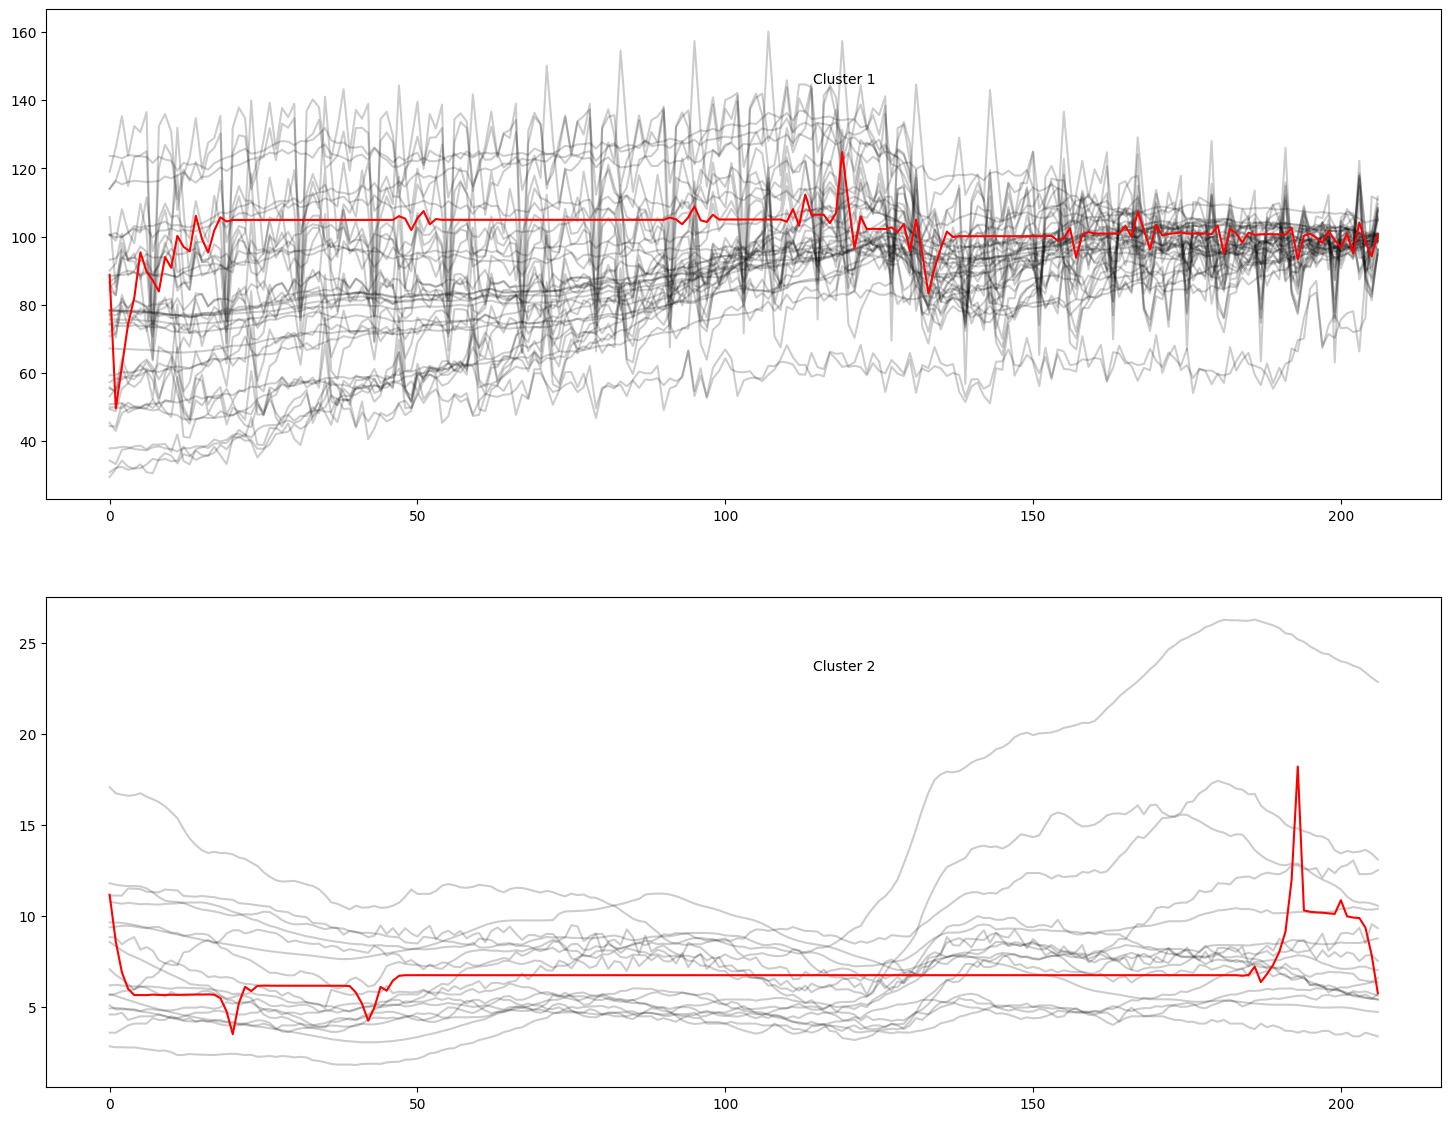

In [39]:
CLUSTER_COUNT = 2
km = TimeSeriesKMeans(n_clusters=CLUSTER_COUNT, metric="dtw", n_jobs=2, n_init=5)
labels = km.fit_predict(X_train)

plt.figure(figsize=(18,14))

for yi in range(CLUSTER_COUNT):
    plt.subplot(CLUSTER_COUNT, 1, yi + 1)
    for xx in X_train[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, 1000)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85, "Cluster %d" % (yi + 1), transform=plt.gca().transAxes)


In [37]:
len(X_train[labels == 7])

4

In [2]:
toto

'a'

In [3]:
def f(a,list=[]):
    for i in range(a):
        list.append(i*i)
    print(list) 
 

In [4]:
f(3)

[0, 1, 4]


In [5]:
f(2)

[0, 1, 4, 0, 1]
